Loading the data

In [14]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# Step 1: Load data from .mat file
data = sio.loadmat('compEx3data.mat')

# Extract variables
Xmodel    = data['Xmodel']         # 4 x N array (homogeneous 3D points)
x1        = data['x'][0, 0]        # 3 x N array of 2D points in image1
x2        = data['x'][0, 1]        # 3 x N array of 2D points in image2
startind  = data['startind'].flatten()  # Indices for plotting lines on the cube
endind    = data['endind'].flatten()    # Indices for plotting lines on the cube

# The above indexing [0, 0] or [0, 1] might vary 
# depending on how the data is structured in the mat file.
# Check with: print(data['x'].shape) or print(data['x'][0]) to be sure.


Normalize 2D points


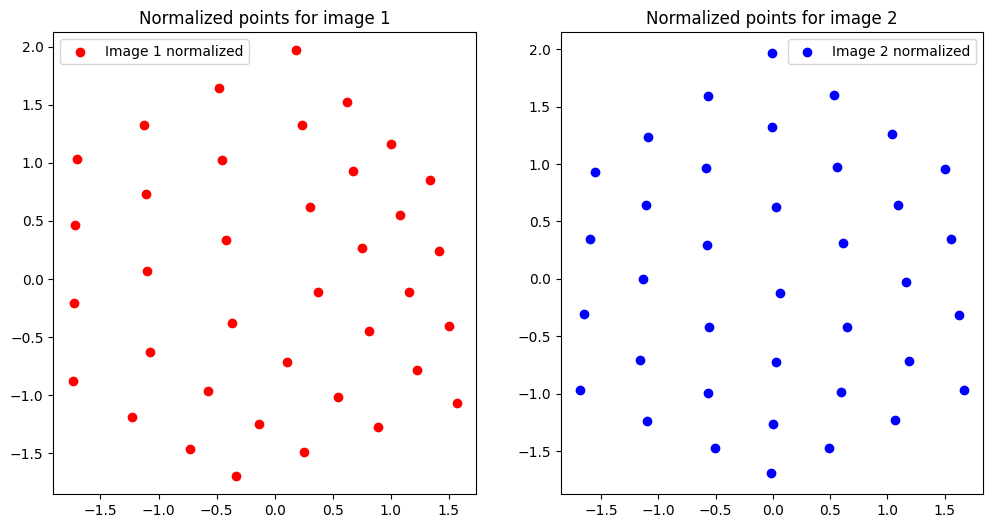

In [13]:
# COMPUTER EXERCISE 3.1

def normalize_2D_points(x):
    """
    x: 3 x N array of homogeneous 2D points [x; y; 1].
       If x is shape (3, N), each column is a point.
    Returns:
        x_norm: 3 x N array of normalized points
        N:      3 x 3 normalization matrix
    """
    # Convert to Cartesian coordinates, ignoring the last row if it is not 1
    x_cart = x[:2, :] / x[2, :]
    
    # 1) Compute mean
    mean_x = np.mean(x_cart[0, :])
    mean_y = np.mean(x_cart[1, :])
    
    # 2) Compute std in each coordinate
    std_x = np.std(x_cart[0, :])
    std_y = np.std(x_cart[1, :])
    
    # Build the normalization matrix N
    # We'll shift by the mean, then scale by 1/std
    # N = [[1/std_x, 0,       -mean_x/std_x ],
    #      [0,       1/std_y, -mean_y/std_y ],
    #      [0,       0,       1           ]]
    N = np.array([[1/std_x, 0,       -mean_x/std_x],
                  [0,       1/std_y, -mean_y/std_y],
                  [0,       0,        1           ]], dtype=float)
    
    # Apply N to x (in homogeneous form)
    x_norm = N @ x
    
    return x_norm, N

# Normalize the 2D points for each image
x1_norm, N1 = normalize_2D_points(x1)
x2_norm, N2 = normalize_2D_points(x2)


# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot normalized points for image 1
axs[0].scatter(x1_norm[0, :], x1_norm[1, :], c='r', label='Image 1 normalized')
axs[0].axis('equal')
axs[0].set_title('Normalized points for image 1')
axs[0].legend()

# Plot normalized points for image 2
axs[1].scatter(x2_norm[0, :], x2_norm[1, :], c='b', label='Image 2 normalized')
axs[1].axis('equal')
axs[1].set_title('Normalized points for image 2')
axs[1].legend()

# Show the plots
plt.show()


Set up DLT equations


In [17]:
# COMPUTER EXERCISE 3.2
def build_dlt_matrix(X, x):
    """
    Build the 2N x 12 matrix for DLT resectioning.
    X: 4 x N array (homogeneous 3D points).
    x: 3 x N array (homogeneous 2D points in normalized coords).
    
    Returns:
        M: 2N x 12 matrix used for homogeneous system M * p = 0
    """
    #print(X.shape)
    #
    # print(x.shape)
    # Ensure Xmodel is in homogeneous coordinates (should be 4xN)
    if X.shape[0] == 3:
        X = np.vstack([Xmodel, np.ones((1, Xmodel.shape[1]))])  # Add a row of ones
   

    N = X.shape[1]
    M = []
    
    for i in range(N):
        X_i = X[:, i]  # 4x1
        x_i = x[:, i]  # 3x1
        
        # Convert to inhom coords just in case
        xi = x_i[0] / x_i[2]
        yi = x_i[1] / x_i[2]
        
        # Rows of M
        # row1: X^T * (first row of P) - x * X^T * (third row of P) => 1 x 12
        # row2: X^T * (second row of P) - y * X^T * (third row of P)
        row1 = [ X_i[0], X_i[1], X_i[2], X_i[3], 0, 0, 0, 0,
                -xi*X_i[0], -xi*X_i[1], -xi*X_i[2], -xi*X_i[3] ]
        
        row2 = [ 0, 0, 0, 0, X_i[0], X_i[1], X_i[2], X_i[3],
                -yi*X_i[0], -yi*X_i[1], -yi*X_i[2], -yi*X_i[3] ]
        
        M.append(row1)
        M.append(row2)
    
    M = np.array(M)
    return M

def solve_dlt(X, x):
    """
    Solve for camera matrix using DLT and SVD.
    Returns 3x4 camera matrix.
    """
    M = build_dlt_matrix(X, x)
    
    # Solve M p = 0 with smallest singular value
    U, S, Vt = np.linalg.svd(M)
    # The last column of V is solution
    p = Vt[-1, :]  # shape (12,)
    
    # Reshape to 3x4
    P = p.reshape(3, 4)  # Corrected reshape to 3x4
    
    # Normalize so that the last entry is 1 if you want a consistent scale
    # But you can also skip if you prefer
    # if P[-1, -1] != 0:
    #    P /= P[-1, -1]
    
    return P

# Solve for P-tilde in normalized coords
P1_tilde = solve_dlt(Xmodel, x1_norm)
P2_tilde = solve_dlt(Xmodel, x2_norm)
print(P1_tilde)
print(P2_tilde)

# Check the smallest singular value
M1 = build_dlt_matrix(Xmodel, x1_norm)
U1, S1, Vt1 = np.linalg.svd(M1)
#print("Singular values:", S1)
smallest_sv = S1[-1]      # Should be close to 0
Mv_norm = np.linalg.norm(M1 @ Vt1[-1, :])  # Norm of Mv
print("Smallest singular value (Image1):", smallest_sv)
print("||M1 v||:", Mv_norm)

M2 = build_dlt_matrix(Xmodel, x2_norm)
U2, S2, Vt2 = np.linalg.svd(M2)
#print("Singular values:", S2)
smallest_sv = S2[-1]      # Should be close to 0
Mv_norm = np.linalg.norm(M2 @ Vt2[-1, :])  # Norm of Mv
print("Smallest singular value (Image2):", smallest_sv)
print("||M2 v||:", Mv_norm)

[[ 0.10413351 -0.01099711 -0.1597092   0.08281875]
 [-0.08005905  0.15966437 -0.06275416  0.85534144]
 [ 0.01131988  0.00739613  0.00713581  0.43472556]]
[[ 0.13122934 -0.00362166 -0.13645265 -0.00224321]
 [-0.07094015  0.16048414 -0.07138061  0.85880576]
 [ 0.00926429  0.00809274  0.00941618  0.43643008]]
Smallest singular value (Image1): 0.0510121207472845
||M1 v||: 0.05101212074728396
Smallest singular value (Image2): 0.04380505110696644
||M2 v||: 0.043805051106966406


Project model points

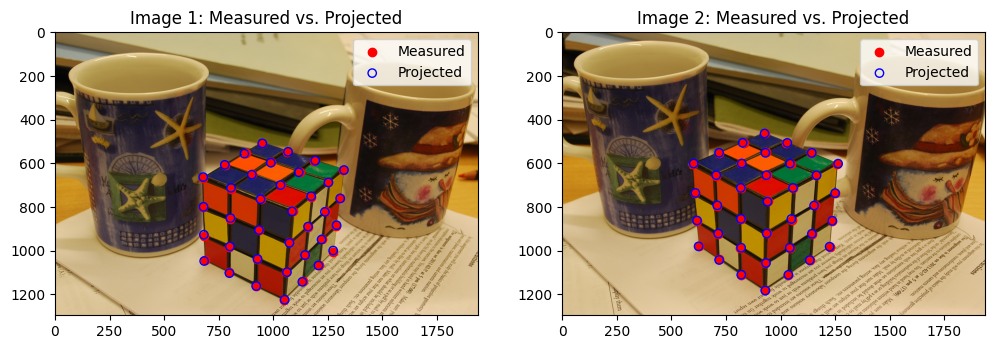

In [10]:
# COMPUTER EXERCISE 3.3


def invert_3x3(N):
    """Convenience function to invert a 3x3 homogeneous-like transform."""
    return np.linalg.inv(N)

P1 = invert_3x3(N1) @ P1_tilde
P2 = invert_3x3(N2) @ P2_tilde
if Xmodel.shape[0] == 3:
    Xmodel = np.vstack([Xmodel, np.ones((1, Xmodel.shape[1]))])  # Add a row of ones

# Ensure P1 and P2 are 3x4 matrices
assert P1.shape == (3, 4), "P1 is not a 3x4 matrix"
assert P2.shape == (3, 4), "P2 is not a 3x4 matrix"
def project_points(P, X):
    """
    P: 3x4 camera matrix
    X: 4xN array of homogeneous 3D points
    
    Returns 3xN array of projected homogeneous 2D points
    """
    x_proj = P @ X  # 3xN
    # convert to inhom
    x_proj /= x_proj[2, :]
    return x_proj

# Project Xmodel into each image using the unnormalized camera matrices
x1_proj = project_points(P1, Xmodel)
x2_proj = project_points(P2, Xmodel)


# Plot them over the measured points (original coords) for Image 1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(plt.imread('cube1.jpg'))  # If you have the image
plt.scatter(x1[0, :] / x1[2, :], x1[1, :] / x1[2, :], c='r', label='Measured')
plt.scatter(x1_proj[0, :], x1_proj[1, :], facecolors='none', edgecolors='b', label='Projected')
plt.title('Image 1: Measured vs. Projected')
plt.legend()

# Plot them over the measured points (original coords) for Image 2
plt.subplot(1, 2, 2)
plt.imshow(plt.imread('cube2.jpg'))  # If you have the image for the second view
plt.scatter(x2[0, :] / x2[2, :], x2[1, :] / x2[2, :], c='r', label='Measured')
plt.scatter(x2_proj[0, :], x2_proj[1, :], facecolors='none', edgecolors='b', label='Projected')
plt.title('Image 2: Measured vs. Projected')
plt.legend()

plt.show()


Compute inner parameters


In [11]:
# COMPUTER EXERCISE 3.4
import scipy.linalg

def rq_decomposition(P):
    """
    Returns R, Q such that P = R * Q.
    By default, 'rq' is not in np.linalg, so we use scipy.linalg.
    """
    # np.linalg.qr does a decomposition but in the opposite order. 
    # We'll do a trick to reorder by flipping the matrix.
    # Or use `scipy.linalg.rq`.
    return scipy.linalg.rq(P)

def decompose_camera(P):
    """
    Decompose 3x4 camera matrix into K, R, t
    Where P = K [R | t], with K upper triangular, diag(K)>0
    """
    # Extract the left 3x3 block
    M = P[:, :3]
    
    R, Q = rq_decomposition(M)
    
    # Enforce positive diagonal in K:
    T = np.diag(np.sign(np.diag(R)))
    R = R @ T
    Q = T @ Q
    
    # K is R, R is Q^T, etc. in the usual notation:
    K = R
    R_ = Q  # rename to not overshadow
    # translation vector is K^-1 times the 3rd column
    t = np.linalg.inv(K) @ P[:, 3]
    
    # Normalize K so that K[2,2] = 1 if desired
    # scale_factor = K[-1, -1]
    # K /= scale_factor
    # t /= scale_factor
    
    return K, R_, t

K1, R1, t1 = decompose_camera(P1)
K2, R2, t2 = decompose_camera(P2)

print("K1:\n", K1)
print("R1:\n", R1)
print("t1:\n", t1)
print("\nK2:\n", K2)
print("R2:\n", R2)
print("t2:\n", t2)


K1:
 [[ 3.70338176e+01 -1.04195755e-01  1.49808573e+01]
 [ 0.00000000e+00  3.70063276e+01  1.06102929e+01]
 [ 0.00000000e+00  0.00000000e+00  1.52892829e-02]]
R1:
 [[ 0.55496751 -0.04813712 -0.8304781 ]
 [-0.37927378  0.87388373 -0.30410299]
 [ 0.74037995  0.48374584  0.46671993]]
t1:
 [ 0.86233863  6.23026076 28.43335205]

K2:
 [[ 3.70375428e+01 -1.68541586e-01  1.31784880e+01]
 [ 0.00000000e+00  3.72620866e+01  1.19301517e+01]
 [ 0.00000000e+00  0.00000000e+00  1.54914137e-02]]
R2:
 [[ 0.71184971  0.00228129 -0.70232812]
 [-0.36828387  0.85269662 -0.37050704]
 [ 0.59802758  0.52240144  0.607832  ]]
t2:
 [ 0.9559556   4.82759471 28.17238544]


Compute RMS error

In [26]:
# COMPUTER EXERCISE 3.5
def rms_error(x_meas, x_proj):
    """
    x_meas, x_proj: 3 x N arrays (homogeneous 2D points)
    returns scalar RMS error in pixel coordinates
    """
    xm = x_meas[:2, :] / x_meas[2, :]
    xp = x_proj[:2, :] / x_proj[2, :]
    diff = xm - xp
    return np.sqrt(np.mean(np.sum(diff**2, axis=0)))

err1 = rms_error(x1, x1_proj)
err2 = rms_error(x2, x2_proj)
print("RMS error, Image 1:", err1, "pixels")
print("RMS error, Image 2:", err2, "pixels")


RMS error, Image 1: 3.5700405905221495 pixels
RMS error, Image 2: 3.164727289631294 pixels
